In [5]:
#!git clone https://github.com/NVlabs/edm 

fatal: destination path 'edm' already exists and is not an empty directory.


In [11]:
import sys
sys.path.append("edm")
from edm.torch_utils import misc
from edm.dnnlib import util
from edm.training.networks import EDMPrecond
from edm import generate

DEVICE = 'cuda'

In [12]:
teacher_model_path = '/kaggle/input/teacher_model_edm/pytorch/default/1/edm-cifar10-32x32-cond-ve (1).pkl'
G_with_lpips_path = '/kaggle/input/student_with_lpips/pytorch/default/1/model_G_16000steps_final (1).pt'
G_without_lpips_path = '/kaggle/input/student_without_lpips/pytorch/default/1/model_G_5000steps (1).pt'

In [13]:
import pickle 
import torch


with open(teacher_model_path, 'rb') as f:
    teacher_model = pickle.load(f)['ema'].train().to(DEVICE)
with open(teacher_model_path, 'rb') as f:  
    G_with_lpips = pickle.load(f)['ema'].train().to(DEVICE)
with open(teacher_model_path, 'rb') as f:
    G_without_lpips = pickle.load(f)['ema'].train().to(DEVICE)

In [14]:
G_with_lpips.load_state_dict(torch.load(G_with_lpips_path)["model_state_dict"])
G_without_lpips.load_state_dict(torch.load(G_without_lpips_path)["model_state_dict"])

<ipython-input-14-0fa5e72a3819>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_with_lpips.load_state_dict(torch.load(G_with_lpips_path)["model_state_dict"])
<ipython-inp

<All keys matched successfully>

In [15]:
T = 100
NUM_CLASSES = 10

In [16]:
from edm import generate

def teacher_gen_samples_batch(model, batch_size, num_steps, class_labels = None, noise = None, schedule = 've', discretization = 've', solver = 'heun'):
    if class_labels is None:
        class_labels = torch.randint(0, NUM_CLASSES,(batch_size,),device=DEVICE)
    labels = torch.zeros((batch_size, NUM_CLASSES), device=DEVICE)
    labels[torch.arange(batch_size),class_labels] = 1

    if noise is None:
        noise = torch.randn(batch_size, 3, 32, 32, device=DEVICE)
    generated_samples = generate.ablation_sampler(model, noise, labels,
                                                  num_steps=num_steps, schedule=schedule,
                                                  scaling="none", discretization=discretization,
                                                  solver=solver)
    return generated_samples, class_labels

In [17]:
def student_gen_samples_batch(model, batch_size, class_labels = None, noise = None):
    if class_labels is None:
        class_labels = torch.randint(0, NUM_CLASSES,(batch_size,),device=DEVICE)
    labels = torch.zeros((batch_size, NUM_CLASSES), device=DEVICE)
    labels[torch.arange(batch_size),class_labels] = 1

    if noise is None:
        noise = torch.randn(batch_size, 3, 32, 32, device=DEVICE)
    const_timestep_G = torch.tensor([T] * batch_size, device=DEVICE)
    generated_samples = model(noise * T, const_timestep_G, class_labels=labels)
    return generated_samples, class_labels

In [18]:
def get_images_from_samples(samples):
    return (samples * 127.5 + 128).clip(0, 255).to(torch.uint8).cpu()

In [19]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader

num_viz = 40
cifar_dataset = CIFAR10(root = '.', train=True, download=True, transform=transforms.ToTensor())
cifar_loader = DataLoader(cifar_dataset, batch_size=num_viz, shuffle=True)

CLASSES_LIST = cifar_dataset.classes

100%|██████████| 170498071/170498071 [00:02<00:00, 71043457.27it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
torch.manual_seed(122333)
noise = torch.randn(num_viz, 3, 32, 32, device=DEVICE)
class_labels = torch.randint(0, NUM_CLASSES,(num_viz,),device=DEVICE)

teacher_samples_heun_500, teacher_classes_heun_500 = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 500)
teacher_samples_euler_500, teacher_classes_euler_500 = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 500, solver = 'euler')

In [21]:
teacher_samples_heun_64, teacher_classes_heun_64 = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 64)
teacher_samples_euler_64, teacher_classes_euler_64 = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 64, solver = 'euler')

In [107]:
student_with_lpips_samples,_ = student_gen_samples_batch(G_with_lpips, num_viz, class_labels, noise)
student_without_lpips_samples,_ = student_gen_samples_batch(G_without_lpips, num_viz, class_labels, noise)

In [25]:
import matplotlib.pyplot as plt
def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

In [23]:
from torchvision.utils import make_grid

def visualize_batch(samples_vis, title='', nrow=10, ncol=4, transform = True):
    if transform:
        samples_vis = get_images_from_samples(samples_vis)
    img_grid = make_grid(samples_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

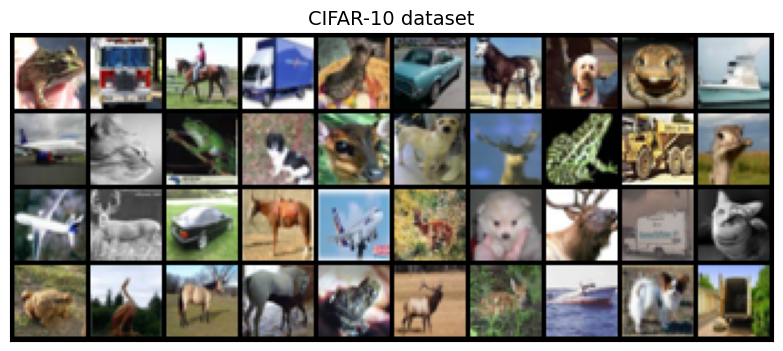

In [114]:
visualize_batch(next(iter(cifar_loader))[0],'CIFAR-10 dataset', transform = False)

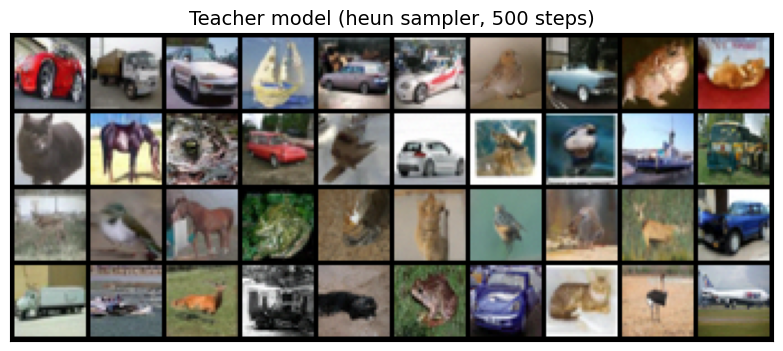

In [115]:
visualize_batch(teacher_samples_heun_500, 'Teacher model (heun sampler, 500 steps)')

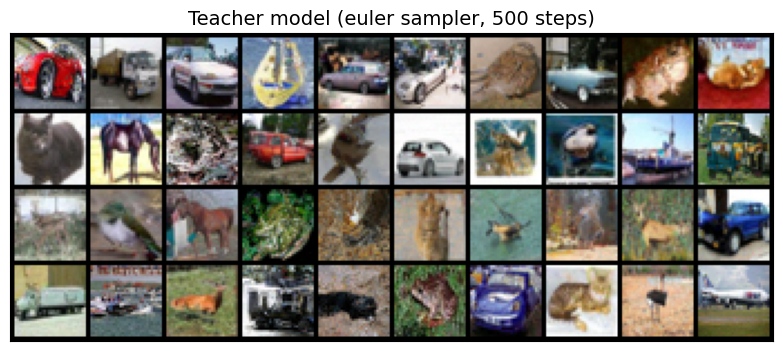

In [116]:
visualize_batch(teacher_samples_euler_500, 'Teacher model (euler sampler, 500 steps)')

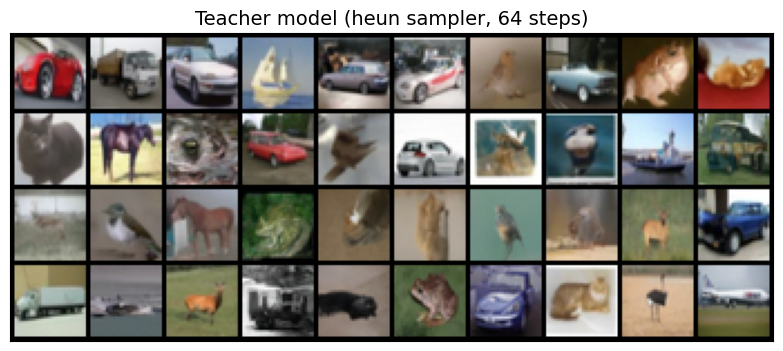

In [26]:
visualize_batch(teacher_samples_heun_64, 'Teacher model (heun sampler, 64 steps)')

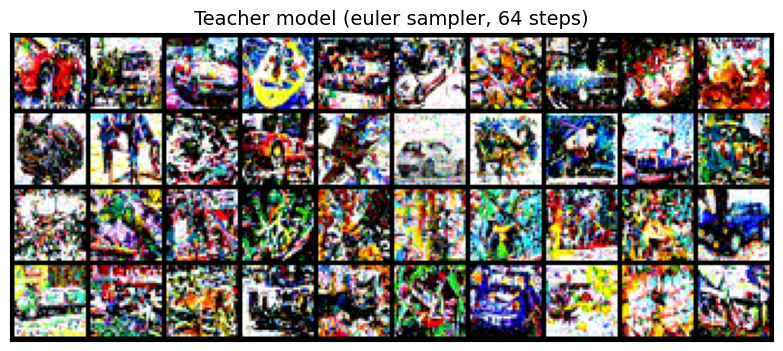

In [27]:
visualize_batch(teacher_samples_euler_64, 'Teacher model (euler sampler, 64 steps)')

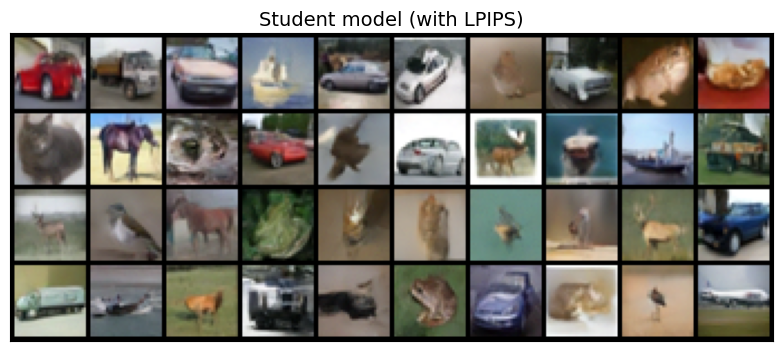

In [117]:
visualize_batch(student_with_lpips_samples, 'Student model (with LPIPS)')

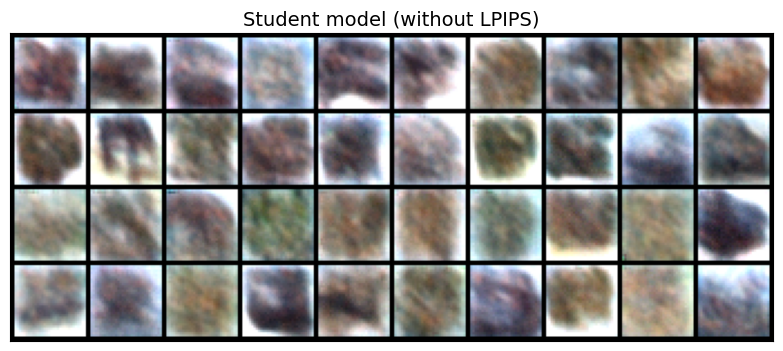

In [118]:
visualize_batch(student_without_lpips_samples, 'Student model (without LPIPS)')

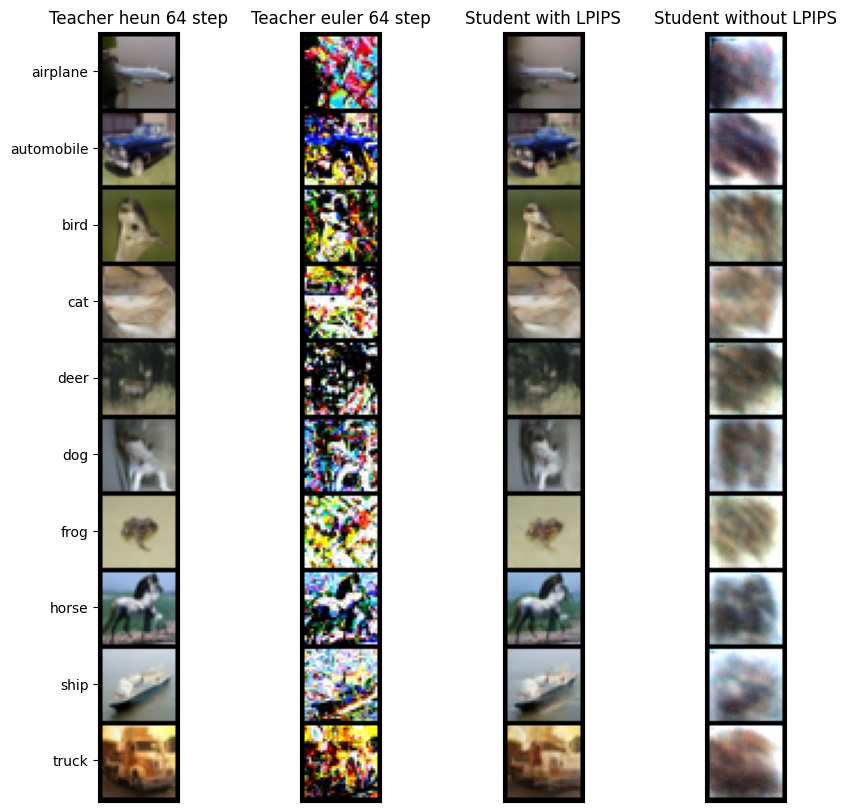

In [31]:
import matplotlib.pyplot as plt 
import numpy as np

num_viz = NUM_CLASSES
fig, axes = plt.subplots(1, 4, figsize=(10, 10))

torch.manual_seed(12)
noise = torch.randn(num_viz, 3, 32, 32, device=DEVICE)
class_labels = torch.tensor(np.arange(NUM_CLASSES), device = DEVICE)

teacher_samples_heun, teacher_classes_heun = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 64)
teacher_samples_euler, teacher_classes_euler = teacher_gen_samples_batch(teacher_model, num_viz, class_labels = class_labels, noise = noise, num_steps = 64, solver = 'euler')

student_with_lpips_samples,_ = student_gen_samples_batch(G_with_lpips, num_viz, class_labels, noise)
student_without_lpips_samples,_ = student_gen_samples_batch(G_without_lpips, num_viz, class_labels, noise)

samples = [teacher_samples_heun, teacher_samples_euler, student_with_lpips_samples, student_without_lpips_samples]
model_names = ['Teacher heun 64 step', 'Teacher euler 64 step', 'Student with LPIPS', 'Student without LPIPS']

for model_idx, generated_images in enumerate(samples):
    img = get_images_from_samples(generated_images)
    ax = axes[model_idx]
    img_grid = make_grid(img, nrow = 1)
    ax.imshow(img_grid.permute(1, 2, 0))
    ax.set_title(f"{model_names[model_idx]}")
    if model_idx == 0:
        ax.set_yticks(
            17 + np.arange(NUM_CLASSES) * 34,
            CLASSES_LIST
        )
        remove_xticks(ax)
    else:
        remove_ticks(ax)

plt.show()

In [32]:
from PIL import Image
import os
import shutil

def save_samples_batch(samples, labels, name, labels_dict, transform = True, count = 0):
  if transform:
    samples = (samples * 0.5 + 0.5)
  samples = (samples * 255).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
  for i in range(samples.shape[0]):
      img = Image.fromarray(samples[i])
      img.save(os.path.join(name, f'image_{count}.png'))
      labels_dict[f'image_{count}.png'] = labels[i].item()
      count += 1

In [33]:
import tqdm

def save_samples(name, num_samples, gen_batch_fn, transform = True, **gen_kwargs):
  count = 0
  if os.path.exists(name):
          shutil.rmtree(name)
  os.makedirs(name, exist_ok=True)
  batch_size = gen_kwargs['batch_size']
  labels_dict = dict()
  for i in tqdm.tqdm(range(0,num_samples, batch_size)):
      generated_samples, labels = gen_batch_fn(**gen_kwargs)
      save_samples_batch(generated_samples,labels, name,labels_dict = labels_dict, transform = transform, count = count)
      count += batch_size
  torch.save(labels_dict, f'{name}_labels_dict.pth')

In [34]:
from edm.training import dataset
import click
def calculate_inception_stats(
    image_path, num_expected=None, seed=0, max_batch_size=64,
    num_workers=3, prefetch_factor=2, device=torch.device('cuda'),
):
    # Load Inception-v3 model.
    # This is a direct PyTorch translation of http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
    print('Loading Inception-v3 model...')
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
    detector_kwargs = dict(return_features=True)
    feature_dim = 2048
    with dnnlib.util.open_url(detector_url, verbose=True) as f:
        detector_net = pickle.load(f).to(device)

    # List images.
    print(f'Loading images from "{image_path}"...')
    dataset_obj = dataset.ImageFolderDataset(path=image_path, max_size=num_expected, random_seed=seed)
    if num_expected is not None and len(dataset_obj) < num_expected:
        raise click.ClickException(f'Found {len(dataset_obj)} images, but expected at least {num_expected}')
    if len(dataset_obj) < 2:
        raise click.ClickException(f'Found {len(dataset_obj)} images, but need at least 2 to compute statistics')

    # Divide images into batches.
    num_batches = ((len(dataset_obj) - 1) // max_batch_size + 1)
    all_batches = torch.arange(len(dataset_obj)).tensor_split(num_batches)
    rank_batches = all_batches
    data_loader = torch.utils.data.DataLoader(dataset_obj, batch_sampler=rank_batches, num_workers=num_workers, prefetch_factor=prefetch_factor)

    # Accumulate statistics.
    print(f'Calculating statistics for {len(dataset_obj)} images...')
    mu = torch.zeros([feature_dim], dtype=torch.float64, device=device)
    sigma = torch.zeros([feature_dim, feature_dim], dtype=torch.float64, device=device)
    for images, _labels in tqdm.tqdm(data_loader, unit='batch', disable=False):
        if images.shape[0] == 0:
            continue
        if images.shape[1] == 1:
            images = images.repeat([1, 3, 1, 1])
        features = detector_net(images.to(device), **detector_kwargs).to(torch.float64)
        mu += features.sum(0)
        sigma += features.T @ features

    # Calculate grand totals.
    mu /= len(dataset_obj)
    sigma -= mu.ger(mu) * len(dataset_obj)
    sigma /= len(dataset_obj) - 1
    return mu.cpu().numpy(), sigma.cpu().numpy()

In [35]:
from edm.fid import calculate_fid_from_inception_stats

def calc_fid(image_path, ref_path, num_expected, batch, npz_path = None):
    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    if npz_path is None:
        ref_mu, ref_sigma = calculate_inception_stats(image_path=ref_path, num_expected=num_expected, max_batch_size=batch)
    else:
        with open_url(npz_path) as f:
            ref = dict(np.load(f))
        ref_mu = ref['mu']
        ref_sigma = ref['sigma']
    fid = calculate_fid_from_inception_stats(mu, sigma, ref_mu, ref_sigma)
    return fid

In [36]:
torch.manual_seed(42)

num_samples = 6000
save_samples('teacher_heun', num_samples, teacher_gen_samples_batch, model = teacher_model, batch_size = 256, num_steps = 64)

100%|██████████| 24/24 [1:49:32<00:00, 273.85s/it]


In [37]:
torch.manual_seed(42)

num_samples = 8700
save_samples('student_with_lpips_8k', num_samples, student_gen_samples_batch, model = G_with_lpips, batch_size = 256)

100%|██████████| 34/34 [01:16<00:00,  2.26s/it]


In [38]:
torch.manual_seed(42)

num_samples = 8700
save_samples('student_without_lpips_8k', num_samples, student_gen_samples_batch, model = G_without_lpips, batch_size = 256)

100%|██████████| 34/34 [01:15<00:00,  2.23s/it]


In [39]:
import shutil
import os

def create_archive(source_dir, archive_name, archive_format='zip'):
    base_name = os.path.abspath(archive_name)
    shutil.make_archive(base_name, archive_format, source_dir)

In [48]:
import os
import torch
import shutil
from PIL import Image
import torchvision.transforms as transforms

def save_tensors_as_images(tensor_file, dest_folder):
    tensors = torch.load(tensor_file)
    os.makedirs(dest_folder, exist_ok=True)

    tensors = (tensors * 127.5 + 128).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
    for i, tensor in enumerate(tensors):
        img = Image.fromarray(tensor)
        img.save(os.path.join(dest_folder, f'train_data_image_{i}.png'))
    
def copy_images_from_folder(src_folder, dest_folder):
    for filename in os.listdir(src_folder):
        source_path = os.path.join(src_folder, filename)
        if os.path.isfile(source_path):
            new_filename = f"{os.path.basename(src_folder)}_{filename}"
            dest_path = os.path.join(dest_folder, new_filename)
            shutil.copy2(source_path, dest_path)

tensor_file = '/kaggle/input/train-paired-dataset/dataset/y.pt'
source_folder = 'teacher_heun'
destination_folder = 'teach_heun_8k' 

os.makedirs(destination_folder, exist_ok=True)
save_tensors_as_images(tensor_file, destination_folder)
copy_images_from_folder(source_folder, destination_folder)


<ipython-input-48-3d47b657dc69>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(tensor_file)


In [55]:
print(len(os.listdir('teach_heun_8k')))

source_dir = 'teach_heun_8k' 
archive_name = 'teacher_heun_all_8k_final'      
archive_format = 'zip'               

create_archive(source_dir, archive_name, archive_format)

8704


In [42]:
def sampler(dataloader):
    def cifar_sampler(*args, **kwargs):
      data_iterator = iter(dataloader)
      cur_batch_size = kwargs['batch_size']
      try:
          images, labels = next(data_iterator)
          return images[:cur_batch_size], labels[:cur_batch_size]
      except StopIteration:
          data_iterator = iter(dataloader)
          images, labels = next(data_iterator)
          return images[:cur_batch_size], labels[:cur_batch_size]

    def ys_sampler(*args,**kwargs):
      return cifar_sampler(**kwargs)[1]

    return cifar_sampler, ys_sampler

In [51]:
from edm.dnnlib import util
import dnnlib
from dnnlib.util import open_url

cifar_ref_path = 'https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz'
fid = calc_fid('teach_heun_8k', '', 8700, batch = 128, npz_path = cifar_ref_path)
print('Teacher model FID = ', fid)

Loading Inception-v3 model...
Loading images from "teach_heun_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:38<00:00,  1.76batch/s]


Teacher model FID =  8.301648586663536


In [56]:
cifar_ref_path = 'https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz'
fid = calc_fid('student_with_lpips_8k', '', 8700, batch = 128, npz_path = cifar_ref_path)
print('Student with LPIPS model FID = ', fid)

Loading Inception-v3 model...
Loading images from "student_with_lpips_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:38<00:00,  1.75batch/s]


Student with LPIPS model FID =  15.074978172284837


In [57]:
cifar_ref_path = 'https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz'
fid = calc_fid('student_without_lpips_8k', '', 8700, batch = 128, npz_path = cifar_ref_path)
print('Student without LPIPS model FID = ', fid)

Loading Inception-v3 model...
Loading images from "student_without_lpips_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:38<00:00,  1.78batch/s]


Student without LPIPS model FID =  221.02959651718885


In [58]:
fid = calc_fid('student_with_lpips_8k', 'teach_heun_8k', 8700, batch = 128, npz_path = None)
print('Student with LPIPS model FID relative to teacher model = ', fid)

Loading Inception-v3 model...
Loading images from "student_with_lpips_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:38<00:00,  1.75batch/s]


Loading Inception-v3 model...
Loading images from "teach_heun_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:38<00:00,  1.78batch/s]


Student with LPIPS model FID relative to teacher model =  10.43395453230118


In [59]:
fid = calc_fid('student_without_lpips_8k', 'teach_heun_8k', 8700, batch = 128, npz_path = None)
print('Student without LPIPS model FID relative to teacher model = ', fid)

Loading Inception-v3 model...
Loading images from "student_without_lpips_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:39<00:00,  1.73batch/s]


Loading Inception-v3 model...
Loading images from "teach_heun_8k"...
Calculating statistics for 8700 images...


100%|██████████| 68/68 [00:37<00:00,  1.79batch/s]


Student without LPIPS model FID relative to teacher model =  218.01466391639497


In [61]:
import dnnlib

detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
feature_dim = 2048
with dnnlib.util.open_url(detector_url, verbose=True) as f:
    detector_net = pickle.load(f).to(DEVICE)

In [62]:
def get_latents_from_images(image_path, detector_net, num_expected=None, seed=0, max_batch_size=64,
    num_workers=3, prefetch_factor=2, device=torch.device('cuda')):
    
    dataset_obj = dataset.ImageFolderDataset(path=image_path, max_size=num_expected, random_seed=seed)
    detector_kwargs = dict(return_features=True)
    num_batches = ((len(dataset_obj) - 1) // max_batch_size + 1)
    all_batches = torch.arange(len(dataset_obj)).tensor_split(num_batches)
    rank_batches = all_batches
    data_loader = torch.utils.data.DataLoader(dataset_obj, batch_sampler=rank_batches, num_workers=num_workers)

    all_features = []
    for images, _labels in tqdm.tqdm(data_loader, unit='batch', disable=False):
        if images.shape[0] == 0:
            continue
        if images.shape[1] == 1:
            images = images.repeat([1, 3, 1, 1])
        features = detector_net(images.to(device), **detector_kwargs).to(torch.float64)
        all_features.append(features)
    return torch.concatenate(all_features, dim = 0)

In [63]:
import numpy as np
torch.manual_seed(122333)
cifar_loader = DataLoader(cifar_dataset, batch_size=512, shuffle=True)
save_samples('real_data_samples_16k', 16000, sampler(cifar_loader)[0], transform = False, batch_size = 512)

100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


In [64]:
torch.manual_seed(122333)
cifar_loader = DataLoader(cifar_dataset, batch_size=512, shuffle=True)
save_samples('real_data_samples_8k', 8000, sampler(cifar_loader)[0], transform = False, batch_size = 512)

100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


In [65]:
torch.manual_seed(122333)
cifar_loader = DataLoader(cifar_dataset, batch_size=512, shuffle=True)
save_samples('real_data_samples_50k', 50000, sampler(cifar_loader)[0], transform = False, batch_size = 512)

100%|██████████| 98/98 [00:26<00:00,  3.68it/s]


In [66]:
teacher_latents = get_latents_from_images('/kaggle/working/teach_heun_8k',detector_net, num_expected = 8700, max_batch_size = 128)
dataset_latents_16k = get_latents_from_images('/kaggle/working/real_data_samples_16k',detector_net, num_expected = 16000, max_batch_size = 128)
dataset_latents_8k = get_latents_from_images('/kaggle/working/real_data_samples_8k',detector_net, num_expected = 8700, max_batch_size = 128)
dataset_latents_50k = get_latents_from_images('/kaggle/working/real_data_samples_50k',detector_net, num_expected = 50000, max_batch_size = 128)
student_with_lpips_latents_8k = get_latents_from_images('/kaggle/working/student_with_lpips_8k',detector_net, num_expected = 8700, max_batch_size = 128)
student_without_lpips_latents_8k = get_latents_from_images('/kaggle/working/student_without_lpips_8k',detector_net, num_expected = 8700, max_batch_size = 128)

100%|██████████| 68/68 [00:38<00:00,  1.78batch/s]


In [74]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm

def kl(p, q):
    assert np.all(np.isfinite(p))
    assert np.all(np.isfinite(q))
    assert not np.any(np.logical_and(p != 0, q == 0))

    p_pos = (p > 0)
    return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))
        
def jensen_shannon(p, q):
    m = (p + q) * 0.5
    return 0.5 * (kl(p, m) + kl(q, m))
        
def two_proportions_z_test(p1, n1, p2, n2, significance_level):
        p = (p1 * n1 + p2 * n2) / (n1 + n2)
        se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        z = (p1 - p2) / se
        p_values = 2.0 * norm.cdf(-1.0 * np.abs(z))
    
        return p_values < significance_level
    
def calculate_ndb(real_features, generated_features, num_bins=10):
    kmeans = KMeans(n_clusters=num_bins, random_state=0)
    kmeans.fit(real_features)
    
    real_labels = kmeans.predict(real_features)
    generated_labels = kmeans.predict(generated_features)

    real_proportion = np.bincount(real_labels, minlength = num_bins) / len(real_labels)
    generated_proportion = np.bincount(generated_labels, minlength = num_bins) / len(generated_labels)
    
    different_bins = two_proportions_z_test(real_proportion, real_features.shape[0], generated_proportion,
                                                    generated_features.shape[0], significance_level=0.01)
    ndb = np.count_nonzero(different_bins)
    js = jensen_shannon(real_proportion, generated_proportion)

    return ndb/num_bins, js

In [68]:
import warnings

warnings.filterwarnings("ignore")

In [69]:
t_ndb = []
t_js = []
bins_list = [15,20,25,30,35,40,45,50, 55, 60]
for bins in tqdm.tqdm(bins_list):
    ndb, js = calculate_ndb(dataset_latents_16k.cpu().numpy(), teacher_latents.cpu().numpy(), num_bins = bins)
    t_ndb.append(ndb)
    t_js.append(js)

100%|██████████| 10/10 [09:34<00:00, 57.47s/it]


In [70]:
s_l_ndb = []
s_l_js = []
bins_list = [15,20,25,30,35,40,45,50, 55, 60]
for bins in tqdm.tqdm(bins_list):
    ndb, js = calculate_ndb(dataset_latents_16k.cpu().numpy(), student_with_lpips_latents_8k.cpu().numpy(), num_bins = bins)
    s_l_ndb.append(ndb)
    s_l_js.append(js)

100%|██████████| 10/10 [09:36<00:00, 57.67s/it]


In [71]:
s_wo_l_ndb = []
s_wo_l_js = []
bins_list = [15,20,25,30,35,40,45,50, 55, 60]
for bins in tqdm.tqdm(bins_list):
    ndb, js = calculate_ndb(dataset_latents_16k.cpu().numpy(), student_without_lpips_latents_8k.cpu().numpy(), num_bins = bins)
    s_wo_l_ndb.append(ndb)
    s_wo_l_js.append(js)

100%|██████████| 10/10 [09:46<00:00, 58.67s/it]


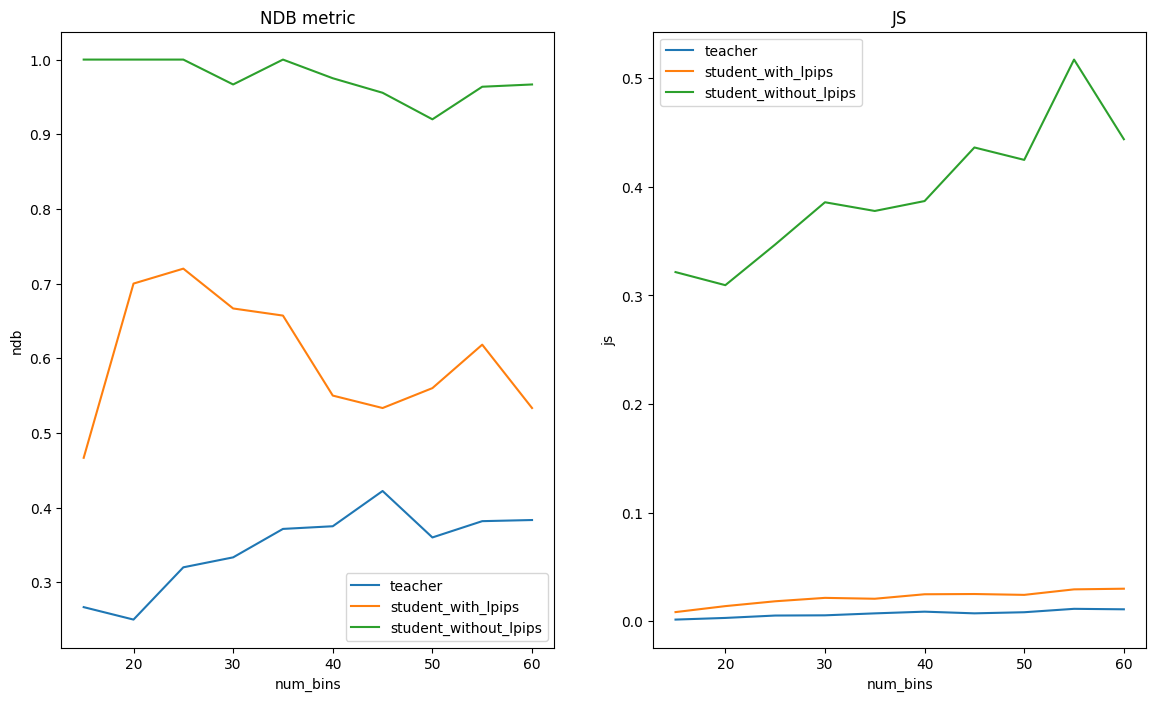

In [81]:
fig, ax = plt.subplots(1,2, figsize=(14, 8))
ax[0].plot(bins_list, t_ndb, label = 'teacher')
ax[0].plot(bins_list, s_l_ndb, label = 'student_with_lpips')
ax[0].plot(bins_list, s_wo_l_ndb, label = 'student_without_lpips')
ax[0].set_xlabel('num_bins')
ax[0].set_title('NDB metric')
ax[0].set_ylabel('ndb')
ax[0].legend()

ax[1].plot(bins_list, t_js, label = 'teacher')
ax[1].plot(bins_list, s_l_js, label = 'student_with_lpips')
ax[1].plot(bins_list, s_wo_l_js, label = 'student_without_lpips')
ax[1].set_xlabel('num_bins')
ax[1].set_title('JS')
ax[1].set_ylabel('js')
ax[1].legend();

In [82]:
import numpy as np
from sklearn.metrics import pairwise_distances

def compute_prdc(real_features, generated_features, nearest_k):
    def compute_pairwise_distance(data_x, data_y=None):
        if data_y is None:
            data_y = data_x
        return pairwise_distances(data_x, data_y, metric='euclidean', n_jobs=8)

    def get_kth_value(unsorted, k, axis=-1):
        indices = np.argpartition(unsorted, k, axis=axis)[..., :k]
        k_smallests = np.take_along_axis(unsorted, indices, axis=axis)
        return k_smallests.max(axis=axis)

    def compute_nearest_neighbour_distances(features, k):
        distances = compute_pairwise_distance(features)
        return get_kth_value(distances, k=k + 1, axis=-1)

    real_nn_distances = compute_nearest_neighbour_distances(real_features, nearest_k)
    generated_nn_distances = compute_nearest_neighbour_distances(generated_features, nearest_k)
    distance_real_gen = compute_pairwise_distance(real_features, generated_features)

    precision = (distance_real_gen < np.expand_dims(real_nn_distances, axis=1)).any(axis=0).mean()
    recall = (distance_real_gen < np.expand_dims(generated_nn_distances, axis=0)).any(axis=1).mean()
    density = (1. / float(nearest_k)) * (distance_real_gen < np.expand_dims(real_nn_distances, axis=1)).sum(axis=0).mean()
    coverage = (distance_real_gen.min(axis=1) < real_nn_distances).mean()

    return {
        'precision': precision,
        'recall': recall,
        'density': density,
        'coverage': coverage
    }

In [83]:
nearest_k_list = [3,4,5,7,9,12,15,20]
teacher_precision_res = []
teacher_recall_res = []
teacher_density_res = []
teacher_coverage_res = []

for nearest_k in tqdm.tqdm(nearest_k_list):
    result = compute_prdc(dataset_latents_16k.cpu().numpy(), teacher_latents.cpu().numpy(), nearest_k)
    teacher_precision_res.append(result['precision'])
    teacher_recall_res.append(result['recall'])
    teacher_density_res.append(result['density'])
    teacher_coverage_res.append(result['coverage'])

100%|██████████| 8/8 [03:35<00:00, 26.99s/it]


In [84]:
nearest_k_list = [3,4,5,7,9,12,15,20]
student_with_lpips_precision_res = []
student_with_lpips_recall_res = []
student_with_lpips_density_res = []
student_with_lpips_coverage_res = []

for nearest_k in tqdm.tqdm(nearest_k_list):
    result = compute_prdc(dataset_latents_16k.cpu().numpy(), student_with_lpips_latents_8k.cpu().numpy(), nearest_k)
    student_with_lpips_precision_res.append(result['precision'])
    student_with_lpips_recall_res.append(result['recall'])
    student_with_lpips_density_res.append(result['density'])
    student_with_lpips_coverage_res.append(result['coverage'])

100%|██████████| 8/8 [03:36<00:00, 27.07s/it]


In [85]:
nearest_k_list = [3,4,5,7,9,12,15,20]
student_without_lpips_precision_res = []
student_without_lpips_recall_res = []
student_without_lpips_density_res = []
student_without_lpips_coverage_res = []

for nearest_k in tqdm.tqdm(nearest_k_list):
    result = compute_prdc(dataset_latents_16k.cpu().numpy(), student_without_lpips_latents_8k.cpu().numpy(), nearest_k)
    student_without_lpips_precision_res.append(result['precision'])
    student_without_lpips_recall_res.append(result['recall'])
    student_without_lpips_density_res.append(result['density'])
    student_without_lpips_coverage_res.append(result['coverage'])

100%|██████████| 8/8 [03:32<00:00, 26.53s/it]


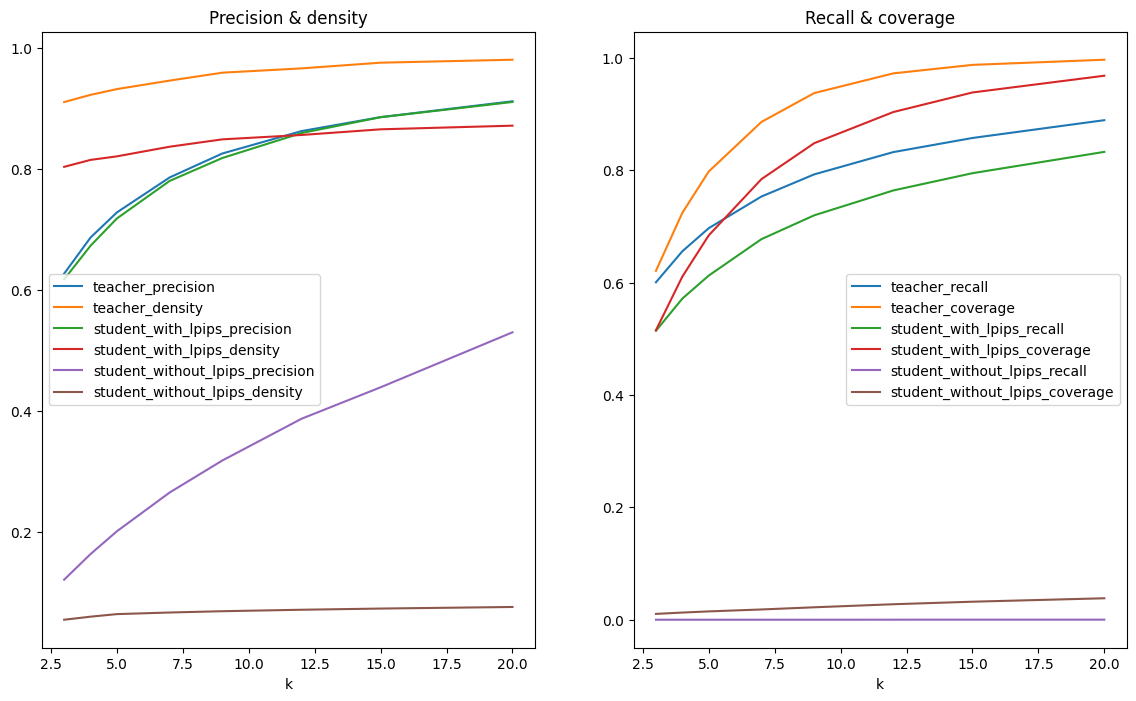

In [86]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,2, figsize=(14, 8))
ax[0].plot(nearest_k_list, teacher_precision_res, label = 'teacher_precision')
ax[0].plot(nearest_k_list, teacher_density_res, label = 'teacher_density', ls = '-')
ax[0].plot(nearest_k_list, student_with_lpips_precision_res, label = 'student_with_lpips_precision')
ax[0].plot(nearest_k_list, student_with_lpips_density_res, label = 'student_with_lpips_density', ls = '-')
ax[0].plot(nearest_k_list, student_without_lpips_precision_res, label = 'student_without_lpips_precision')
ax[0].plot(nearest_k_list, student_without_lpips_density_res, label = 'student_without_lpips_density', ls = '-')
ax[0].set_xlabel('k')
ax[0].set_title('Precision & density')
ax[0].legend()

ax[1].plot(nearest_k_list, teacher_recall_res, label = 'teacher_recall')
ax[1].plot(nearest_k_list, teacher_coverage_res, label = 'teacher_coverage',ls = '-')
ax[1].plot(nearest_k_list, student_with_lpips_recall_res, label = 'student_with_lpips_recall')
ax[1].plot(nearest_k_list, student_with_lpips_coverage_res, label = 'student_with_lpips_coverage', ls = '-')
ax[1].plot(nearest_k_list, student_without_lpips_recall_res, label = 'student_without_lpips_recall')
ax[1].plot(nearest_k_list, student_without_lpips_coverage_res, label = 'student_without_lpips_coverage', ls = '-')
ax[1].set_xlabel('k')
ax[1].set_title('Recall & coverage')
ax[1].legend();

In [87]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms

def perceptual_distance(img1, img2):
    latents1 = detector_net(img1, return_features = True)
    latents2 = detector_net(img2, return_features = True)
    return F.mse_loss(latents1, latents2)

def slerp(t, low, high):
    shape = low.shape
    low = low.flatten(start_dim = 1)
    high = high.flatten(start_dim = 1)
    low = low / torch.norm(low, dim=-1, keepdim=True)
    high = high / torch.norm(high, dim=-1, keepdim=True)
    d = torch.sum(low * high, dim = -1, keepdims = True)
    u = torch.acos(torch.clamp(d, -1, 1))
    s = torch.sin(u)
    low_part = (torch.sin((1.0 - t) * u) / s) * low
    high_part = (torch.sin(t * u) / s) * high
    return  (low_part + high_part).reshape(shape)

def compute_ppl(generator_fn, class_labels = None, num_samples=1000, num_steps_inter=10, device='cuda', **gen_params):
    ppl_values = []
    batch_size = gen_params['batch_size']
    for _ in tqdm.tqdm(range(num_samples // batch_size)):
        if class_labels is None:
            class_labels = torch.randint(0, NUM_CLASSES, size=(batch_size,), device = device)
        z_start = torch.randn(batch_size, 3, 32, 32, device=device)
        z_end = torch.randn(batch_size, 3, 32, 32, device=device)

        for t in tqdm.tqdm(range(1, num_steps_inter)):
            fraction = t / num_steps_inter
            z_t = slerp(fraction, z_start, z_end)
            img_t = get_images_from_samples(generator_fn(noise = z_t.to(device), class_labels = class_labels, **gen_params)[0]).float()
            img_t = img_t.to(device)
            if t > 1: 
                dist = perceptual_distance(img_t_prev, img_t)
                ppl_values.append(dist.item() / ((z_t - z_t_prev).norm().item() + 1e-7))
            
            img_t_prev = img_t
            z_t_prev = z_t
            
    return sum(ppl_values) / len(ppl_values)

In [88]:
torch.manual_seed(12345)
compute_ppl(teacher_gen_samples_batch, num_samples = 512, num_steps_inter = 10, model = teacher_model, batch_size = 256, num_steps = 64)

100%|██████████| 2/2 [1:22:23<00:00, 2471.89s/it]


0.00025691945558130904

In [89]:
torch.manual_seed(12345)
compute_ppl(student_gen_samples_batch, num_samples = 512, num_steps_inter = 10, model = G_with_lpips, batch_size = 256)

100%|██████████| 2/2 [01:16<00:00, 38.18s/it]


0.007416443485638472

In [90]:
torch.manual_seed(12345)
compute_ppl(student_gen_samples_batch, num_samples = 512, num_steps_inter = 10, model = G_without_lpips, batch_size = 256)

100%|██████████| 2/2 [01:16<00:00, 38.15s/it]


0.007725048977688659

In [91]:
t_ppl = 0.00025691945558130904
s_l_ppl = 0.007416443485638472
s_wo_l_ppl = 0.007725048977688659
print('Teacher PPL =',t_ppl)
print('Student with LPIPS PPL =', s_l_ppl)
print('Student without LPIPS PPL =', s_wo_l_ppl)

Teacher PPL = 0.00025691945558130904
Student with LPIPS PPL = 0.007416443485638472
Student without LPIPS PPL = 0.007725048977688659
